# Training Curve Plotting
Plot average reward curve with std shading from TensorBoard logs for used for image creation from log for documentation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load data from all runs
log_dir = "logs/standard_rl" # relative path,
run_dirs = glob.glob(f"{log_dir}/run_*/sac_run_*_*")

all_eps = []
all_timesteps = []

print(f"Found {len(run_dirs)} runs")

for run_dir in sorted(run_dirs):
    event_files = glob.glob(f"{run_dir}/**/events.out.tfevents.*", recursive=True)
    
    if event_files:
        ea = EventAccumulator(event_files[0])
        ea.Reload()
        
        if 'rollout/ep_len_mean' in ea.scalars.Keys():
            ep_len_data = ea.scalars.Items('rollout/ep_len_mean')
            timesteps = [x.step for x in ep_len_data]
            ep_len = [x.value for x in ep_len_data]
            
            all_timesteps.append(timesteps)
            all_eps.append(ep_len)
            print(f"{run_dir}: {len(timesteps)} data points")
        
print(f"\nLoaded {len(all_eps)} runs successfully")

Found 5 runs
logs/standard_rl/run_1/sac_run_1_1: 764 data points
logs/standard_rl/run_2/sac_run_2_1: 787 data points
logs/standard_rl/run_3/sac_run_3_1: 805 data points
logs/standard_rl/run_4/sac_run_4_1: 796 data points
logs/standard_rl/run_5/sac_run_5_1: 782 data points

Loaded 5 runs successfully


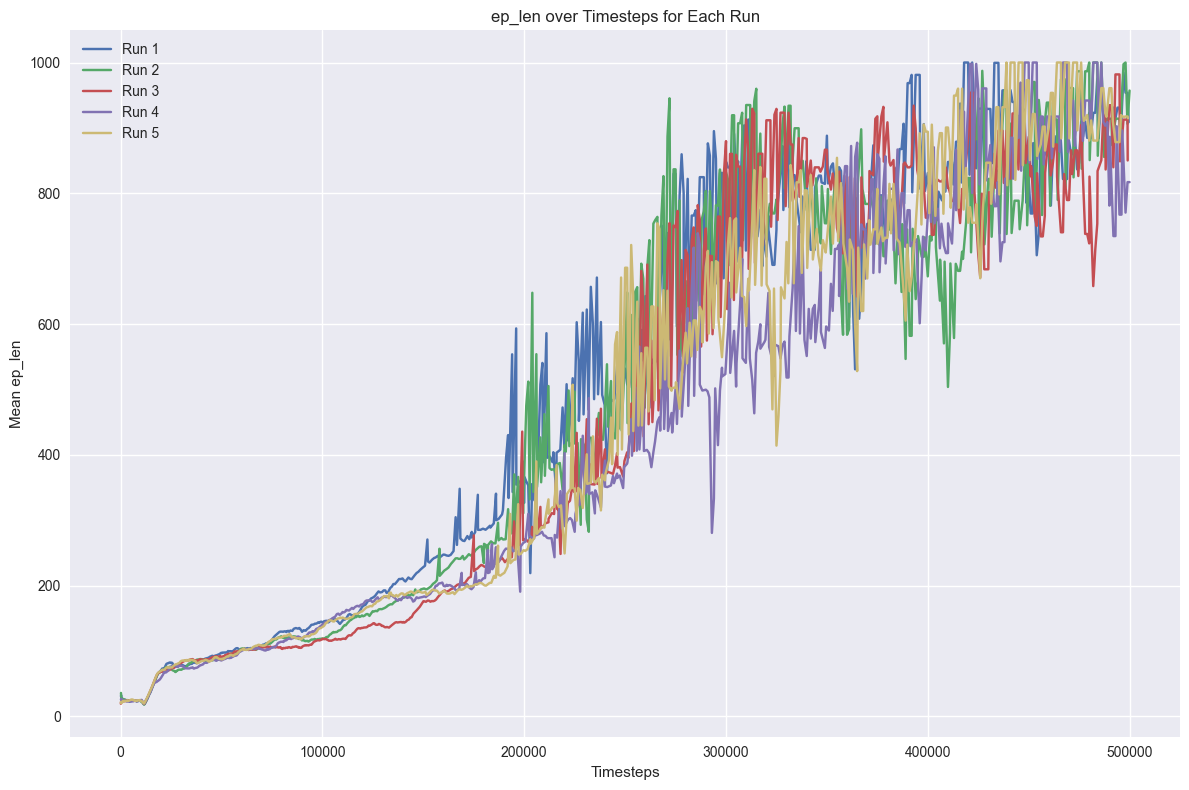

In [3]:
import matplotlib.pyplot as plt

# Plot each run's rewards over timesteps
plt.figure(figsize=(12, 8))
for i, (timesteps, rewards) in enumerate(zip(all_timesteps, all_eps)):
    plt.plot(timesteps, rewards, label=f'Run {i + 1}')

plt.title('ep_len over Timesteps for Each Run')
plt.xlabel('Timesteps')
plt.ylabel('Mean ep_len')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Find common length and interpolate
min_length = min(len(ep_len) for ep_len in all_eps)
max_timesteps = max(max(timesteps) for timesteps in all_timesteps)

# Use timesteps from first run (they should be similar)
common_timesteps = all_timesteps[0][:min_length]

# Truncate all runs to same length
truncated_ep_lens = [ep_len[:min_length] for ep_len in all_eps]

# Convert to numpy for easy math
ep_len_matrix = np.array(truncated_ep_lens)
mean_ep_len = np.mean(ep_len_matrix, axis=0)
std_ep_len= np.std(ep_len_matrix, axis=0)

print(f"Using {min_length} data points from 0 to {max(common_timesteps)} timesteps")

Using 764 data points from 0 to 499543 timesteps


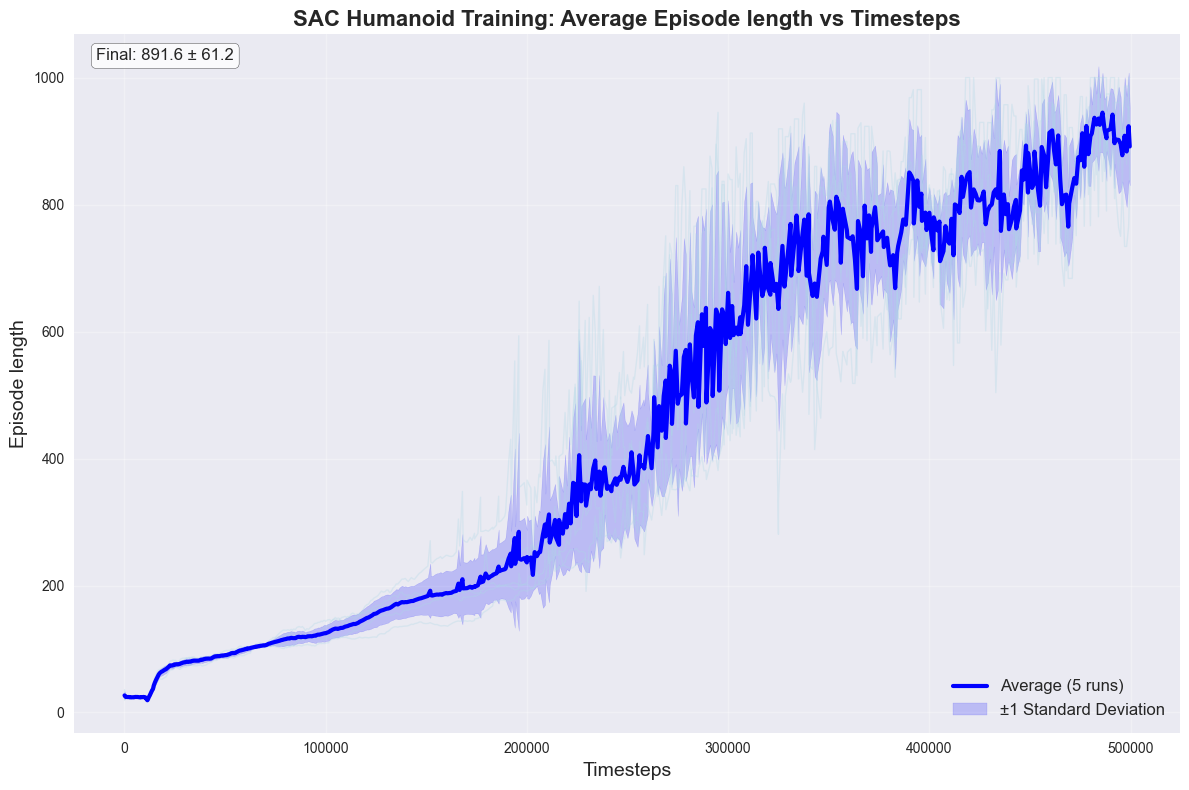


Final performance: 891.58 ± 61.24
Saved plot as: training_curve.png


In [8]:
# Create the plot
plt.figure(figsize=(12, 8))

# Plot individual runs (light)
for i, ep_len in enumerate(truncated_ep_lens):
    plt.plot(common_timesteps, ep_len, alpha=0.3, color='lightblue', linewidth=1)

# Plot average curve (bold)
plt.plot(common_timesteps, mean_ep_len, color='blue', linewidth=3, 
         label=f'Average ({len(all_eps)} runs)')

# Add std shading
plt.fill_between(common_timesteps, 
                 mean_ep_len - std_ep_len, 
                 mean_ep_len + std_ep_len, 
                 alpha=0.2, color='blue', label='±1 Standard Deviation')

# Formatting
plt.title('SAC Humanoid Training: Average Episode length vs Timesteps', fontsize=16, fontweight='bold')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Episode length', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add final stats
final_mean = mean_ep_len[-1]
final_std = std_ep_len[-1]
plt.text(0.02, 0.98, f'Final: {final_mean:.1f} ± {final_std:.1f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('training_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal performance: {final_mean:.2f} ± {final_std:.2f}")
print(f"Saved plot as: training_curve.png")